In [1]:
import pandas as pd
import pint_pandas
import logging
import tinarm
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
### Configure Logging
LOGGING_LEVEL = logging.INFO

logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-03-08 10:10:42,161 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - tinarm version 0.1
2024-03-08 10:10:42,161 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - pint_pandas version 0.5


In [3]:
operating_points = [op_point for op_point in os.listdir('M2') if os.path.isdir(os.path.join('m2',op_point))]

In [4]:
operating_points

['Nominal_46Nm_2420rpm',
 'PeakPowerMaxSpeed_31Nm_3300rpm',
 'NominalPowerMaxSpeed_30Nm_3300rpm',
 'PeakTorqueBaseSpeed_69Nm_1610rpm']

In [5]:
for op_point in operating_points:
    print(f"Processing {op_point}")
    chart = [c for c in os.listdir(os.path.join('M2',op_point)) if c.endswith('.csv')]
    chart.sort()
    print(chart)

Processing Nominal_46Nm_2420rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv', 'modBackEmf.csv']
Processing PeakPowerMaxSpeed_31Nm_3300rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv']
Processing NominalPowerMaxSpeed_30Nm_3300rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv']
Processing PeakTorqueBaseSpeed_69Nm_1610rpm
['BackEmf.csv', 'CurrentAngle.csv', 'IronLoss.csv', 'MagnetLoss.csv', 'PhaseVoltage.csv', 'Torque.csv', 'modBackEmf.csv']


In [6]:
expected_charts = ['BackEmf.csv', 'CurrentAngle.csv',
                   'IronLoss.csv', 'MagnetLoss.csv',
                   'PhaseVoltage.csv', 'Torque.csv']


In [26]:
op_point = operating_points[1]
df = pd.read_csv(os.path.join('M2', op_point, expected_charts[0]), index_col=None, header=[0,1])

In [27]:
num_phases = 3
num_pole_pairs = 5


In [28]:
theta_m = np.hstack((np.deg2rad(df['EMFa']['X'] ),
          np.deg2rad((df['EMFb']['X']-(360/num_pole_pairs/num_phases))),
          np.deg2rad((df['EMFc']['X']+(360/num_pole_pairs/num_phases)))))


In [29]:

v_emf = np.hstack((df['EMFa']['Y'],
            df['EMFb']['Y'],
            df['EMFc']['Y']))


   

In [30]:
not_nan  = np.logical_not(np.logical_and(np.isnan(theta_m), np.isnan(v_emf)))
theta_m = theta_m[not_nan]
v_emf = v_emf[not_nan]
sort_idx = np.argsort(theta_m)

In [31]:
coefs = np.array([ 2.13067617e-01,  1.22822323e+02, -4.00576570e-01, -8.28698521e-01,
       -9.96330324e-02, -1.11853145e+00, -2.27614394e-01,  2.32197231e-01,
        2.34067377e-01,  5.18779813e-01,  5.52624693e-02,0,0])

n_idx = np.arange(1, 2*len(coefs)-1, 2)

In [32]:
def predict(coefs, theta, num_pole_pairs=5):
    n_idx = np.arange(1, 2*len(coefs)-1, 2)
    pred = np.matmul(coefs[1:], np.cos(np.outer(n_idx, coefs[0]+theta*num_pole_pairs)))
    return pred

def loss(coefs, theta, v_emf):
    pred = predict(coefs, theta)
    return np.sum((v_emf - pred)**2)

In [33]:
#optimise the coefficients
from scipy.optimize import minimize
#set bounds that the coefficients must be positive
bounds = [(None, None) for _ in range(len(coefs))]
bounds[0] = (0, 2*np.pi/num_pole_pairs)

In [34]:
res = minimize(loss, coefs,
               args=(theta_m, v_emf),
               method='Nelder-Mead', tol=1e-6,
               bounds=bounds,
               options={'disp': True, "maxiter":9000})
print(res)

pred = predict(res.x, theta_m[sort_idx])


Optimization terminated successfully.
         Current function value: 759.082771
         Iterations: 5379
         Function evaluations: 7314
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 759.0827712998871
             x: [ 2.141e-01  2.500e+02 ...  4.335e-02 -9.313e-02]
           nit: 5379
          nfev: 7314
 final_simplex: (array([[ 2.141e-01,  2.500e+02, ...,  4.335e-02,
                        -9.313e-02],
                       [ 2.141e-01,  2.500e+02, ...,  4.335e-02,
                        -9.313e-02],
                       ...,
                       [ 2.141e-01,  2.500e+02, ...,  4.335e-02,
                        -9.313e-02],
                       [ 2.141e-01,  2.500e+02, ...,  4.335e-02,
                        -9.313e-02]]), array([ 7.591e+02,  7.591e+02, ...,  7.591e+02,  7.591e+02]))


In [35]:
res.x

array([ 2.14130163e-01,  2.50025336e+02, -1.22932089e+01, -3.71892236e+00,
        3.47741117e-01, -3.00663399e-01,  6.42107545e-01, -9.59447769e-01,
        9.60993725e-02, -2.31264400e-01,  4.92970469e-02,  4.33504835e-02,
       -9.31253860e-02])

In [36]:
phase_emf_a = -res.x[0]/num_pole_pairs
phase_emf_b = -res.x[0]/num_pole_pairs +(2*np.pi / num_pole_pairs / num_phases)
phase_emf_c = -res.x[0]/num_pole_pairs +2*(2*np.pi / num_pole_pairs / num_phases)

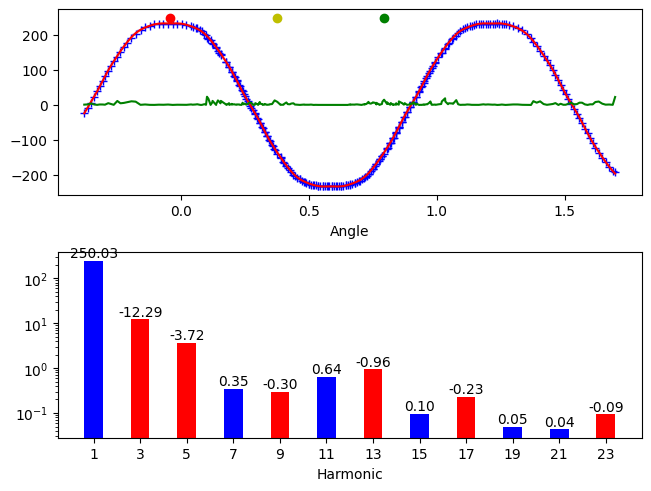

In [37]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(theta_m[sort_idx], v_emf[sort_idx], 'b+')
ax_t.plot(theta_m[sort_idx], pred, 'r-')
ax_t.set_xlabel('Angle')
# plot the error
ax_t.plot(theta_m[sort_idx], (v_emf[sort_idx] - pred)**2, 'g-')

ax_t.plot(phase_emf_a, res.x[1], 'ro')
ax_t.plot(phase_emf_b, res.x[1], 'yo')
ax_t.plot(phase_emf_c, res.x[1], 'go')

ax_w.bar(n_idx, abs(res.x[1:]), color = ['r' if res.x[i] < 0 else 'b' for i in range(1, len(res.x))])
ax_w.set_xlabel('Harmonic')
ax_w.set_yscale('log')
ax_w.set_xticks(n_idx)
for i in range(1, len(res.x)):
    ax_w.text(n_idx[i-1], abs(res.x[i]), f"{res.x[i]:.2f}", ha='center', va='bottom')

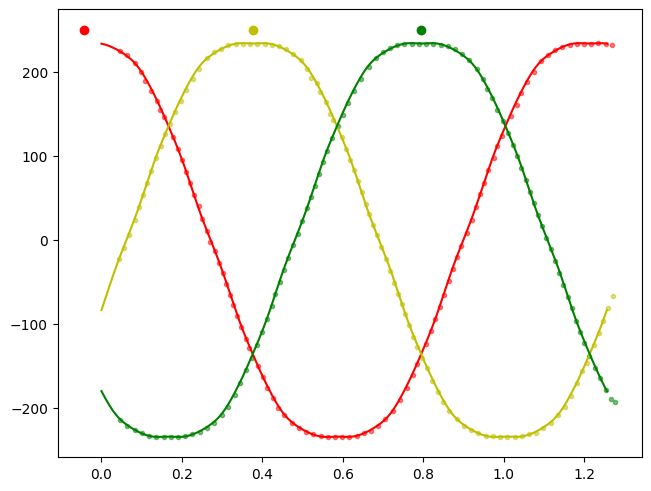

In [38]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.deg2rad(df['EMFa']['X']), df['EMFa']['Y'], 'r.', alpha=0.5)
ax_t.plot(np.deg2rad(df['EMFb']['X']), df['EMFb']['Y'], 'y.', alpha=0.5)
ax_t.plot(np.deg2rad(df['EMFc']['X']), df['EMFc']['Y'], 'g.', alpha=0.5)
theta = np.linspace(0, 2*np.pi/num_pole_pairs, 1000)
ax_t.plot(theta, predict(res.x, theta), 'r-')
ax_t.plot(theta, predict(res.x, theta-(2*np.pi/num_pole_pairs/num_phases)), 'y-')
ax_t.plot(theta, predict(res.x, theta+(2*np.pi/num_pole_pairs/num_phases)), 'g-')
ax_t.plot(phase_emf_a, res.x[1], 'ro')
ax_t.plot(phase_emf_b, res.x[1], 'yo')
ax_t.plot(phase_emf_c, res.x[1], 'go')

new_df = pd.DataFrame({'theta': pd.Series(theta, dtype='pint[rad]'),
                       'emf a': pd.Series(predict(res.x, theta), dtype='pint[V]'),
                       'emf b': pd.Series(predict(res.x, theta-(2*np.pi/num_pole_pairs/num_phases)), dtype='pint[V]'),
                       'emf c': pd.Series(predict(res.x, theta+(2*np.pi/num_pole_pairs/num_phases)), dtype='pint[V]')})


In [39]:
new_df.pint.dequantify().to_csv(os.path.join('M2', op_point, "mod"+expected_charts[0]), index=False)


In [40]:
current_df = pd.read_csv(os.path.join('M2', op_point, expected_charts[1]),
                         index_col=None, header=[0,1])
current_df

EMFb                     Ib            
            X           Y          X           Y
0    2.511774  -21.693269   2.498819   97.678912
1    3.271608   -7.282002   3.284549  109.848521
2    4.006944    6.984733   4.087910  123.081194
3    4.703251   22.955413   4.743194  137.410305
4    5.306597   38.711832   5.653251  151.116412
..        ...         ...        ...         ...
86  70.625694 -113.215649  72.822569   64.365458
87  71.322001  -98.827203        NaN         NaN
88  71.948138  -83.697085        NaN         NaN
89  72.585069  -68.997137        NaN         NaN
90  73.060069  -61.001908        NaN         NaN

[91 rows x 4 columns]

In [41]:
current_coef = np.array([1.5, 75]) #initial guess offset and amplitude
bounds = [(None, None) for _ in range(len(current_coef))]



def predict_current(coefs, theta, num_pole_pairs=5):
    pred = coefs[1] * np.cos(coefs[0] - (theta * num_pole_pairs))
    return pred

def loss_current(coefs, theta, current):
    current_b = predict_current(coefs, theta)
    return np.sum((current - current_b)**2)

res_current = minimize(loss_current, current_coef,
                       args=(np.deg2rad(current_df['Ib']['X']),
                             current_df['Ib']['Y']),
                             method='Nelder-Mead',
                             tol=1e-6,
                             bounds=bounds,)
print(res_current)

ib_mag = res_current.x[1]
phase_current_b = (res_current.x[0])/num_pole_pairs
print(phase_current_b)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 133.5066468167143
             x: [ 1.365e+00  2.383e+02]
           nit: 75
          nfev: 141
 final_simplex: (array([[ 1.365e+00,  2.383e+02],
                       [ 1.365e+00,  2.383e+02],
                       [ 1.365e+00,  2.383e+02]]), array([ 1.335e+02,  1.335e+02,  1.335e+02]))
0.2730693645070279


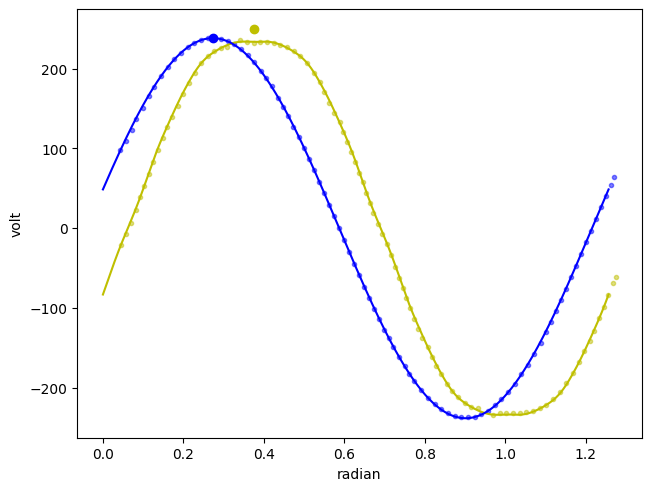

In [42]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.deg2rad(current_df['EMFb']['X']),
          current_df['EMFb']['Y'], 'y.', alpha=0.5)
ax_t.plot(np.deg2rad(current_df['Ib']['X']),
          current_df['Ib']['Y'], 'b.', alpha=0.5)

ax_t.plot(phase_emf_b, res.x[1], 'yo')
ax_t.plot(phase_current_b, ib_mag, 'bo')
ax_t.plot(new_df['theta'], new_df['emf b'], 'y-')
ax_t.plot(new_df['theta'], predict_current(res_current.x, new_df['theta'].pint.magnitude), 'b-')

In [43]:
torque_df = pd.read_csv(os.path.join('M2', op_point, 'Torque.csv'),
                         index_col=None, header=[0,1])
torque_df

Torque           
            X          Y
0    2.422339  31.146674
1    3.163057  31.154444
2    3.903775  31.053435
3    4.644493  30.820338
4    5.385210  30.595011
..        ...        ...
91  69.827661  31.535169
92  70.568379  31.418621
93  71.309097  31.193293
94  72.049814  30.921347
95  72.684715  30.835878

[96 rows x 2 columns]

In [89]:
arg_idx = np.argsort(np.deg2rad(torque_df['Torque']['X'])%(np.pi/5/3))

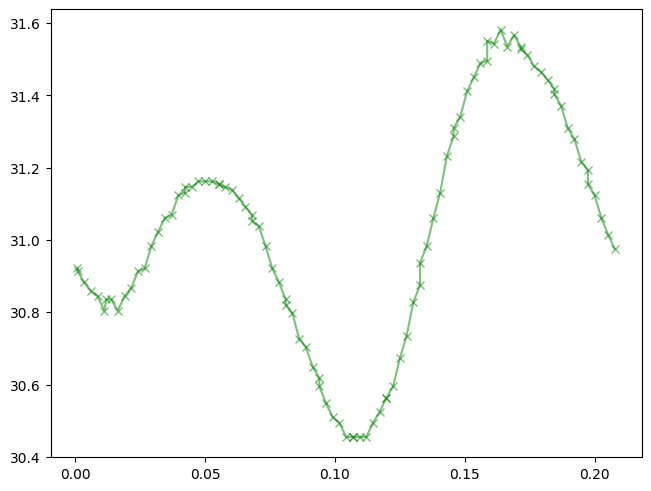

In [90]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3),
          torque_df['Torque']['Y'][arg_idx], 'g-x', alpha=0.5)

In [140]:
def torque_predict(coefs, theta, harm=[6, 12, 24, 30, 33, 36, 40, 43, 46], num_pole_pairs=5):
    pred = coefs[0] + np.matmul(coefs[2:], np.cos(np.outer(harm, (coefs[1]+theta))))
    return pred
def torque_loss(coefs, theta, torque):
    pred = torque_predict(coefs, theta)
    return np.sum((torque - pred)**2)


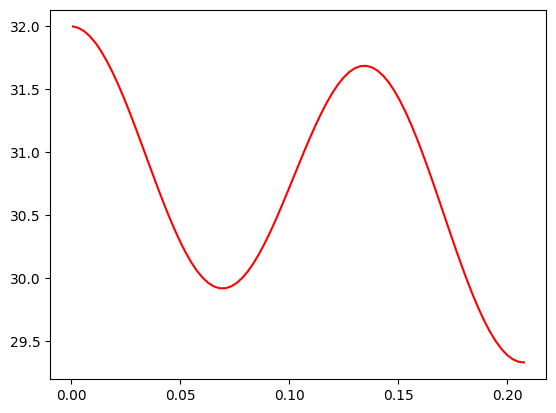

In [142]:
torque_coefs = np.array([30, 0, 1,0,0, 0,0,0, 0,0,1])
test = torque_predict(torque_coefs, np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3))
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), test, 'r-')

In [143]:

torque_coefs = np.array([30, 0, 1, -1, 1, 0, 0])
bounds = [(None, None) for _ in range(len(torque_coefs))]
bounds[0] = (28, 32)
res_torque = minimize(torque_loss, torque_coefs, args=(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3),
                             torque_df['Torque']['Y'][arg_idx]),
                             method='Nelder-Mead',
                             tol=1e-6,
                             bounds=bounds,
                             options={'disp': True, "maxiter":9000})
print(res_torque)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9 is different from 5)

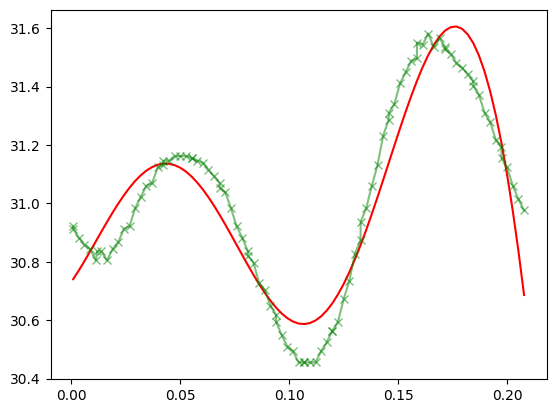

In [134]:
test = torque_predict(res_torque.x, np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3))
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), test, 'r-')
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), torque_df['Torque']['Y'][arg_idx], 'g-x', alpha=0.5)

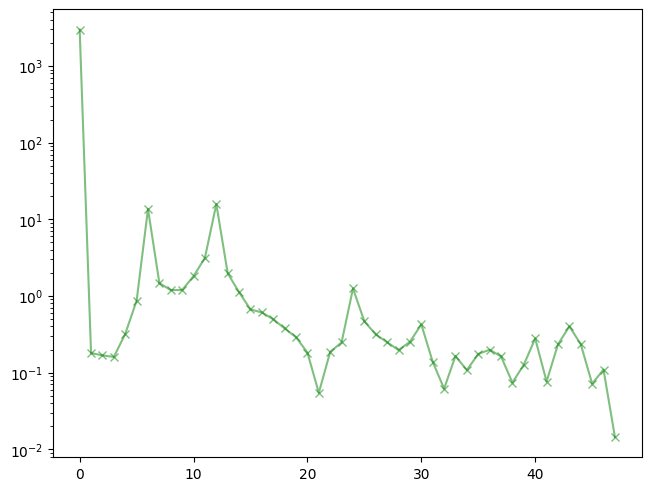

In [80]:
#do a fft on the torque
from scipy.fft import fft
torque_fft = fft(torque_df['Torque']['Y'].values, n=torque_df['Torque']['Y'].size, )
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.abs(torque_fft[0:int(torque_df['Torque']['Y'].size/2)]), 'g-x', alpha=0.5)
ax_t.set_yscale('log')

In [81]:
#detect the peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(np.abs(torque_fft[0:int(torque_df['Torque']['Y'].size/2)]), height=0.1)
peaks

array([ 6, 12, 24, 30, 33, 36, 40, 43, 46])

In [75]:
#make a copy of the fft with only the peaks
torque_fft_peaks = np.zeros_like(torque_fft)
torque_fft_peaks[peaks] = torque_fft[peaks]

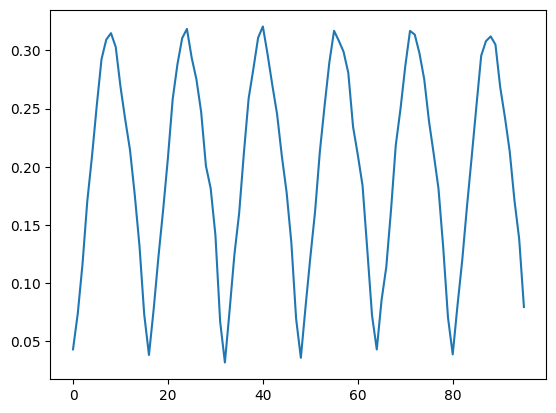

In [78]:
# produce a waveform from the ifft of the peaks and the phase

from scipy.fft import ifft
torque_waveform = ifft(torque_fft_peaks)
plt.plot(abs(torque_waveform))

In [73]:
abs(ifft(torque_fft))

array([31.14667394, 31.15444384, 31.05343511, 30.82033806, 30.59501091,
       30.45515267, 30.5639313 , 30.93688659, 31.30984188, 31.55070883,
       31.52739913, 31.4030807 , 31.15444384, 30.91357688, 30.83587786,
       30.92134678, 31.12336423, 31.16221374, 31.09228462, 30.88249727,
       30.64940022, 30.45515267, 30.52508179, 30.82810796, 31.23214286,
       31.48854962, 31.56624864, 31.44193021, 31.21660305, 30.9757361 ,
       30.80479826, 30.91357688, 31.06897492, 31.16221374, 31.11559433,
       30.92134678, 30.70378953, 30.49400218, 30.49400218, 30.73486914,
       31.13113413, 31.44970011, 31.53516903, 31.46523991, 31.27876227,
       31.01458561, 30.84364776, 30.86695747, 31.06120502, 31.16221374,
       31.13890403, 30.983506  , 30.72709924, 30.50954198, 30.45515267,
       30.67270992, 31.06120502, 31.4108506 , 31.58178844, 31.48077972,
       31.30984188, 31.06120502, 30.85918757, 30.84364776, 31.02235551,
       31.14667394, 31.14667394, 31.03789531, 30.79702835, 30.54